In [ ]:
# imports
# -------

# Necessary imports - done
# ------------------------

import os
from PIL import Image
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
import copy
import cv2
from os import listdir
from os.path import isfile, join
import time
import multiprocessing
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
import math

import torch.autograd as autograd
import torch
from torchvision import models
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from __future__ import print_function
from io import BytesIO

# neccessary imports for imgaug
# ------------------------------
import imgaug as ia
from imgaug import augmenters as iaa

###
###
%matplotlib inline
%env JOBLIB_TEMP_FOLDER=/tmp


# printing platform info
# ----------------------
import platform
print(platform.python_version())

env: JOBLIB_TEMP_FOLDER=/tmp
3.6.9


In [ ]:
# printing torch
# -------------
torch.cuda.is_available()

True

In [ ]:
# colab related imports & mounting drive
# --------------------------------------
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#!unzip '/content/drive/My Drive/datasets/mask_nomask_faces.zip' -d '/content/drive/My Drive/datasets/'
#!ls '/content/drive/My Drive/datasets/'

**helper function code begins**

In [ ]:
# MAIN ON THE GO STANDARD IMGAUG CODE
# -----------------------------------
def imgaug_onthego_std(x_in):

    '''

    factors to generalise across

    1. colour -- grayscale
    2. scale -- aug.perspectivescale
    3. perspective -- aug.perspectivescale
    4. variations in core shape -- aug.elastic_transformation
    5. finding objects within complex structures e.g., bird inside text -- aug.BlendAlphaRegularGrid
    6. partial structures / occlusion -- aug.coarsedropout

    '''

    # 0. initialisations
    # ------------------
    # none for now
    
    
    # 1. setting the augmentation pipeline
    # ------------------------------------
    seq = iaa.Sequential([
        
        iaa.SaltAndPepper(0.1),
        iaa.Fliplr(0.5),

    ])
    
    
    # 2. main augmentation step
    # -------------------------
    image_aug= seq(images=x_in.astype('uint8'))
    
    # 3. final return
    # ---------------
    return image_aug


In [ ]:
# main function to work out precisin, recall and f1 scores
# --------------------------------------------------------

def precision_recall_f1_accuracy(pin,yin,target_act,labels_list):
    
    '''
    
    1. takes in p as numpy and y as numpy
    2. also takes in labels_dict & other params
    2. works out precision, recall & f1 score for all labels
    
    '''
    
    # 0. initialisations
    # ------------------
    d = {}
    y = copy.deepcopy(yin)
    if target_act == 'softmax':
        p = softmax_to_onehot(copy.deepcopy(pin))
    else:
        p = (pin >= 0.5).astype(float)
        
    # 1. accuracy
    # -----------
    total_right = np.sum((np.sum((p==y).astype(float), axis = 1) == y.shape[1]).astype(float))
    accuracy = round((total_right/(y.shape[0] + 0.0001))*100, 2)
    print('Basic accuracy: ' + str(accuracy) + '%')
        
        
    # 1. itering
    # ----------
    for keys in range(len(labels_list)):
        
        # output dict initialisations
        # ---------------------------
        d[keys] = {}
        d[keys]['label'] = labels_list[keys]
        
        # precision work out
        # ------------------
        true_curr_label = np.sum(p[:,keys]*y[:,keys])
        all_pred_curr_label = np.sum(p[:,keys])
        curr_precision = true_curr_label/(all_pred_curr_label + 0.0001)
        
        # recall work out
        # ---------------
        all_actual_curr_label = np.sum(y[:,keys])
        curr_recall = true_curr_label/(all_actual_curr_label + 0.0001)
        
        # f1 score workout
        # ----------------
        curr_f1 = 2 * ((curr_precision * curr_recall)/(curr_precision + curr_recall + 0.0001))
        
        # saving to dict
        # --------------
        d[keys]['precision'] = round(curr_precision,2)
        d[keys]['recall'] = round(curr_recall,2)
        d[keys]['f1'] = round(curr_f1,2)
        
        

    # final printing
    # --------------
    print('\nPrecision, recall and f1 scores: \n********************************\n')
    
    for keys in d:
        print('Label: ' + str(d[keys]['label']))
        print('------------')
        print('Precision: ' + str(d[keys]['precision']))
        print('Recall: ' + str(d[keys]['recall']))
        print('F1 Score: ' + str(d[keys]['f1']))
        print('\n')
    
    # final return
    # ------------
    return d


In [ ]:
# function for CAM - class activatinon map
# -----------------------------------------

def CAM(xin, model, layer=16):

  # 0. inits
  # --------
  h,w = xin.size()[2],xin.size()[3]
  xin_np = to_numpy_image(xin)
  out_d = {}

  # 1. getting and saving preds
  # ---------------------------
  pred_out = model.eval()(xin/torch.max(xin))
  pred_out[pred_out < 0.5] = 0
  pred_out[pred_out >= 0.5] = 1

  # 2. getting sub model
  # ---------------------
  model_sub = nn.Sequential(model.image_encoder)[0][0:layer]

  # 3. getting feature maps at this sub layer
  # -----------------------------------------
  f_maps = model_sub.eval()(xin/torch.max(xin))  

  # 4. sum the feature maps along the channel axis
  # ----------------------------------------------
  f_maps_sum_init = torch.sum(f_maps, 1)

  # 5. normalise the summed feature map
  # output of this step will be in range 0-1
  # ----------------------------------------
  f_maps_sum_init[f_maps_sum_init < 0] = 0
  f_maps_sum = torch.zeros((f_maps_sum_init.size()))

  # example wise normalisation
  # --------------------------
  for i in range(f_maps_sum.size()[0]):

    f_maps_sum[i] = f_maps_sum_init[i]/torch.max(f_maps_sum_init[i])
    f_maps_sum[i] = (f_maps_sum_init[i] - torch.min(f_maps_sum_init[i]))/(torch.max(f_maps_sum_init[i]) - torch.min(f_maps_sum_init[i]))

  # 6. convert to np heatmap resized image
  # --------------------------------------
  f_maps_sum_np = to_numpy_image(f_maps_sum.view(f_maps_sum.size()[0],1,f_maps_sum.size()[1],f_maps_sum.size()[2]))

  # 7. resizing & itering to build final out
  # ----------------------------------------
  for i in range(f_maps_sum_np.shape[0]):

    # 1. resizing
    # ------------
    f_maps_sum_np_curr_resized = cv2.resize(f_maps_sum_np[i,:,:,0],(w,h))
    f_maps_sum_np_curr_resized = f_maps_sum_np_curr_resized.reshape(h,w,1)

    # 2. creating heat map
    # --------------------
    heat_map = cv2.applyColorMap(np.uint8(255*(1-f_maps_sum_np_curr_resized)), cv2.COLORMAP_JET)
    heat_map = heat_map/np.max(heat_map)
    curr_visual_image = xin_np[i]/np.max(xin_np[i])
    overlayed_img = heat_map * 0.5 + curr_visual_image * 0.5

    # 3. append to dict
    # -----------------
    out_d[i] = {}
    out_d[i]['pred'] = pred_out[i]
    out_d[i]['heatmap'] = overlayed_img
  

  # 8. final return
  # ----------------
  return out_d



In [ ]:
# function to create train and test set true to their prior distributions
# -----------------------------------------------------------------------

def return_train_test_set(xin,yin,train_set_threshold):

  # 0. inits
  # --------
  # none for now

  # 1. iterting thru all classes
  # ----------------------------
  for i in range(yin.shape[1]):

    # getting inds
    # ------------
    curr_class_inds = np.argwhere(yin[:,i] == 1)[:,0]
    x_curr = xin[curr_class_inds]
    y_curr = yin[curr_class_inds]

    # thresholding 
    # ------------
    curr_threshold = int(train_set_threshold * x_curr.shape[0])
    x_curr_train = x_curr[0:curr_threshold]
    y_curr_train = y_curr[0:curr_threshold]
    x_curr_test = x_curr[curr_threshold:]
    y_curr_test = y_curr[curr_threshold:]

    # concatenating
    # -------------
    try:

      x_train_out = np.concatenate((x_train_out,x_curr_train), axis = 0)
      y_train_out = np.concatenate((y_train_out,y_curr_train), axis = 0)

      x_test_out = np.concatenate((x_test_out,x_curr_test), axis = 0)
      y_test_out = np.concatenate((y_test_out,y_curr_test), axis = 0)
    
    except:

      x_train_out = x_curr_train
      y_train_out = y_curr_train

      x_test_out = x_curr_test
      y_test_out = y_curr_test

  

  # thats it
  # final out
  # ---------
  return x_train_out, y_train_out, x_test_out, y_test_out



In [ ]:
# a simple scaling function
# -------------------------
def scale(img, feature_range=(-1, 1)):

  '''
  Scales the input image into given feature_range
  '''
  min,max = feature_range
  img = img * (max-min) + min
  return img


# GENERIC function to calculate conv outsize
# -------------------------------------------- 
def outsize_conv(n_H,n_W,f,s,pad):
    
    h = ((n_H - f + (2*pad))/s) + 1
    w = ((n_W - f + (2*pad))/s) + 1
    return h,w
    
    
# GENERIC function to calculate upconv outsize
# --------------------------------------------    
def outsize_upconv(h,w,f,s,p):
    hout = (h-1)*s - 2*p + f
    wout = (w-1)*s - 2*p + f
    return hout, wout



# GENERIC - initialises weights for a NN
# --------------------------------------
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        
        
# GENERIC - change an torch image to numpy image
# ----------------------------------------------
def to_numpy_image(xin):
    
    try:
        xin = xin.data.numpy()
    except:
        xin = xin.numpy()
    
    xout = np.swapaxes(xin,1,2)
    xout = np.swapaxes(xout,2,3)
    
    # returns axes swapped numpy images
    # ---------------------------------
    return xout       



# GENERIC - converts numpy images to torch tensors for training
# -------------------------------------------------------------
def setup_image_tensor(xin):
    xout = np.swapaxes(xin,1,3)
    xout = np.swapaxes(xout,2,3)
    
    # returns axes swapped torch tensor
    # ---------------------------------
    xout = torch.from_numpy(xout)
    return xout.float()


# SIMPLE FUNTION TO CONVERT RGB TO GRAYSCALE
# -------------------------------------------
def rgb2gray(x):
    

    x[:,:,:,0] = x[:,:,:,0] * 0.2989
    x[:,:,:,1] = x[:,:,:,0] * 0.5870
    x[:,:,:,2] = x[:,:,:,0] * 0.1140
    xout = np.sum(x,axis = 3)
    

    #r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    #gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return xout.astype('uint8')



# simple snippet to find out the distribution of class values
# -----------------------------------------------------------
def return_class_distribution(yin, labels_list):
    
    '''
    
    1. returns a simple dict with number of examples in each class in y
    2. input must be of shape (m,c)
    3. returns d[class_number] = num_examples
    
    '''
    
    # 0. initialisations
    # ------------------
    m,c = yin.shape
    d = {}
    
    # 1. looping through classes
    # --------------------------
    for curr_c in range(c):
        d[labels_list[curr_c]] = np.argwhere(yin[:,curr_c] == 1).shape[0]
    
    # 2. printing results
    # -------------------
    for keys in d:
        print('class ' + str(keys) + ': ' + str(d[keys]))
    
    # 3. final return
    # ---------------
    return d

    

In [ ]:
# pool function to resize

def resize_pool(x,h,w):
    
    
    '''
    
    input must be of size (m,h,w,c)
    
    '''
    
    # sanity
    # ------
    assert len(x.shape) == 4,'Error: input must be in format m,h,w,c'
    
    # 0. inits
    # --------
    global x_to_be_resized
    x_to_be_resized = copy.deepcopy(x)
    
    global to_h,to_w
    to_h,to_w = h,w
    
    global x_resized
    x_resized = np.zeros((x.shape[0],h,w,x.shape[3]), dtype='uint8')
    
    # 1. pool function
    # ----------------
    pool = ThreadPool(5) 
    pool.map(resize_single, list(range(x.shape[0])))
    
    # closing pools
    # -------------
    pool.terminate()
    pool.join()
    
    
# single function
# --------------
def resize_single(i):
    
    # 0. getting global inits
    # -----------------------
    global x_to_be_resized
    global to_h,to_w
    global x_resized
    
    
    # 1. resize
    # ---------
    curr_img = x_to_be_resized[i]
    curr_img = cv2.resize(curr_img,(to_w,to_h))
    x_resized[i] = curr_img
    
    
    
    
    

In [ ]:
# master wrapper to create product dict
# -------------------------------------
def create_multiclass_trainset_pool(master_folder,h,w,gray_flag):

    '''

    1. wrapper to create a prod dict in format d[i]['img'] = np image, d[i]['class'] = 'prod name'
    2. input must be a master folder with format - 

    master_folder--

        --- prod_1
            ------ img1.jpg
            ------ img2.jpg

        --- prod_2
            ------ img1.jpg
            ------ img2.jpg

    '''
    
    # 0. inits
    # --------
    # none
    
    # 1. all class folders
    # ---------------------
    global use_gray
    use_gray = gray_flag
    
    class_folder = [f for f in listdir(master_folder) if os.path.isdir(join(master_folder,f))]
    try:
        class_folder.remove('.DS_Store')
    except:
        pass
    
    # 1.2 iter through class folders to create direct img paths
    # image_list will be list in format [(path,class_name)...]
    # ---------------------------------------------------------
    global image_list_with_class
    image_list_with_class = []
    
    # main iter
    # ---------
    print('1. building master image list..')
    for each_class in class_folder:
        infolder = join(master_folder,each_class)
        image_list_jpg = [join(infolder,f) for f in listdir(infolder) if isfile(join(infolder, f)) and '.jpg' in f.lower() and '.DS_Store'.lower() not in f.lower()]
        image_list_jpeg = [join(infolder,f) for f in listdir(infolder) if isfile(join(infolder, f)) and '.jpeg' in f.lower() and '.DS_Store'.lower() not in f.lower()]
        image_list_png = [join(infolder,f) for f in listdir(infolder) if isfile(join(infolder, f)) and '.png' in f.lower() and '.DS_Store'.lower() not in f.lower()]
        image_list_with_class += [(each_class,f) for f in image_list_jpg + image_list_png + image_list_jpeg]
        
    
    
    # 2. some global inits before calling pooling functions
    # -----------------------------------------------------
    global class_labels
    class_labels = class_folder
    
    global counter
    counter = 0
    
    global multi_class_d
    multi_class_d = {}
    
    # setting key lists
    # -----------------
    for each in class_labels:
        multi_class_d[each] = []
    
    global img_h_in,img_w_in
    img_h_in,img_w_in = h,w
    
    # 3. calling pooled functino
    # --------------------------
    pool = ThreadPool(5) 
    pool.map(create_multiclass_trainset_single, list(range(len(image_list_with_class))))
    print('2. done with dicts creation..')
    
    # closing pools
    # -------------
    pool.terminate()
    pool.join()
    
    # 4. NOW to numpy these dicts
    # ----------------------------
    print('3. building numpy set..')
    
    # setting channel variable
    # ------------------------
    if use_gray == True:
        c = 1
    else:
        c = 3
    x_out = np.zeros((0,h,w,c), dtype='uint8')
    y_out = np.zeros((0,len(class_labels)))
    
    
    # itering thru keys
    # -----------------
    for keys in multi_class_d:
        
        # np ops
        # ------
        curr_img_set = np.array(multi_class_d[keys])
        curr_img_set = curr_img_set.reshape(len(multi_class_d[keys]),h,w,c)
        curr_yout = np.zeros((len(multi_class_d[keys]),len(class_labels)))                     
        curr_yout[:,class_labels.index(keys)] = 1
        
        # concat
        # ------
        x_out = np.concatenate((x_out,curr_img_set), axis = 0)
        y_out = np.concatenate((y_out,curr_yout), axis = 0)
        
        

    # shuffling
    # ---------
    assert x_out.shape[0] == y_out.shape[0],'Error: xout and yout have different lengths.'
    np.random.seed(10)
    shuff_inds = np.random.permutation(x_out.shape[0])
    x_out = np.take(x_out,shuff_inds,axis=0)
    y_out = np.take(y_out,shuff_inds,axis=0)
    
    
    # final return
    # ------------
    return x_out,y_out
    
    
# single function
# ---------------
def create_multiclass_trainset_single(i):
    
    # 0. global inits
    # ---------------
    global use_gray
    global image_list_with_class
    global counter
    global multi_class_d
    global img_h_in,img_w_in
    
    # 1. ops
    # ------
    curr_img_class = image_list_with_class[i][0]
    curr_img_url = image_list_with_class[i][1]
    
    # 2. reading image
    # ----------------
    #try:
    if use_gray == True:
        img = cv2.resize(cv2.cvtColor(cv2.imread(curr_img_url), cv2.COLOR_BGR2GRAY),(img_w_in,img_h_in))
        img = img.reshape(img_w_in,img_h_in,1)
    else:
        img = cv2.resize(cv2.cvtColor(cv2.imread(curr_img_url), cv2.COLOR_BGR2RGB),(img_w_in,img_h_in))

    multi_class_d[curr_img_class].append(img)
    counter += 1
        
    #except:
        
    #    print(curr_img_url)
        
    
    # sanity
    # ------
    print('done with ' + str(counter) + ' of around ' + str(len(image_list_with_class)) + ' images...', end='\r')
    
    

**model training code**

In [ ]:
# a function to load a saved model
# --------------------------------

def load_saved_model_function_cpu(path):
    
    
    ''' path = /folder1/folder2/model_ae.tar format'''
    
    # 1. loading full model
    # ---------------------
    model = torch.load(path.replace('.tar','_MODEL.tar'))
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad,model.parameters()))
    
    # 2. Applying state dict
    # loads to CPU
    # torch.load(checkpoint_file, map_location=‘cpu’)
    # ------------------------------------------------
    checkpoint = torch.load(path, map_location='cpu')
    
    # loading checkpoint
    # -------------------
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # loading optimizer
    # -----------------
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    
    # loading other stuff
    # -------------------
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    loss_mode = checkpoint['loss_mode']
    
    return model, optimizer, epoch, loss, loss_mode
    
    


In [ ]:
# a function to load a saved model
# --------------------------------

def load_saved_model_function(path, use_cuda):
    
    
    ''' path = /folder1/folder2/model_ae.tar format'''
    
    # 1. loading full model
    # ---------------------
    model = torch.load(path.replace('.tar','_MODEL.tar'))
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad,model.parameters()))
    
    # 2. Applying state dict
    # ----------------------
    if use_cuda == True:
        
        # loads to GPU
        # ------------
        checkpoint = torch.load(path)
        
    else:
        # loads to CPU
        # ------------
        checkpoint = torch.load(path, map_location=lambda storage, loc: storage)
        
        
    # loading checkpoint
    # -------------------
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # loading optimizer
    # -----------------
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if use_cuda == True:
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.cuda()
            
            
            
    # loading other stuff
    # -------------------
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    loss_mode = checkpoint['loss_mode']
    
    return model, optimizer, epoch, loss, loss_mode
    
    


In [ ]:
# GENERIC model function to train the networks
# --------------------------------------------
def model_train(xin,yin,load_mode,model,epochs,mbsize,save_state,base_name,path):
    
    
    # 0. initialisations
    # x_small,y = create_multiclass_trainset_pool(master_url,img_h,img_w,use_grayscale,None)
    # --------------------------------------------------------------------------------------
    
    
    # 1. OPTIMIZER SETTINGS
    # WGAN values from paper
    # https://arxiv.org/pdf/2006.14380.pdf
    # optimiser is ADAM
    ######################################
    criterion = nn.MSELoss()
    gpu_device = torch.device('cuda')
    cpu_device = torch.device("cpu")
    use_cuda = True
    loss_mode = 'mse'
    
    
    # 2. loading model
    # eiher from saved state or new
    # -----------------------------
    if load_mode == 'from saved':
        
        # 1. 
        # loading GEN from saved
        # ----------------------
        model,optimizer,saved_epoch,saved_loss,saved_loss_mode = load_saved_model_function_cpu(path + base_name + '.tar')
        model = model.to(cpu_device)        
        model = model.train()
        
        print('Loading model from saved state...')
        print('Last saved recons loss - ' + str(saved_loss))
        print('Last saved recons epoch - ' + str(saved_epoch))
        epochs += int(saved_epoch)
        start_epoch = int(saved_epoch)
        print('**********************')
        
        
        
    else:
        
        # building new
        # ------------
        start_epoch = 1
        
        # 1. GEN
        # ------
        model = model.train()
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad,model.parameters()))

        
  
    
    # 3. multi GPU support
    ##############################
    ##############################
    # MAIN MULTI GPU SUPPORT CODE
    # https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html#create-model-and-dataparallel
    # ------------------------------------------------------------------------------------------------------

    # over here we will consider the model to be of NOT dataparrale + cuda  optimised
    # if multi GPU available
    # -------------------------------------------------------------------------------
    if use_cuda == True:

        # gen
        # ---
        model.to(gpu_device)
        
        # updating optimiser
        # -------------------
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(gpu_device)

          
        # sanity
        # ------
        print("finished setting models up for GPU..")
    
            
    # 4. MAIN ACTUAL ITERS
    #######################
    #######################
    #######################
    for i in range(start_epoch,epochs+1):
        
            
        ###################################
        # this is random based train method
        ###################################

        # 1. randomly sampling
        # --------------------
        randrange_conditional = random.sample(list(range(xin.size()[0])), mbsize)
        yin_cond_mb = yin[randrange_conditional]
        xin_cond_mb = xin[randrange_conditional]

        # augmenting data on the go
        # -------------------------
        xin_cond_mb_np = to_numpy_image(copy.deepcopy(xin_cond_mb))
        xin_cond_mb_aug = imgaug_onthego_std(xin_cond_mb_np)
        xin_cond_mb = Variable(setup_image_tensor(xin_cond_mb_aug)).float()
        xin_cond_mb = xin_cond_mb/torch.max(xin_cond_mb)


        # 3. moving to gpu
        # ----------------
        xin_cond_mb = xin_cond_mb.to(gpu_device)
        yin_cond_mb = yin_cond_mb.to(gpu_device)


        # 4. main training ops
        # --------------------
        optimizer.zero_grad()
        model_out = model(xin_cond_mb)
        loss = criterion(model_out, yin_cond_mb) # input, target
        loss.backward()
        optimizer.step()

        
        # 5. printing ops
        # ---------------
        split_loss = 'cls loss: ' + str(round(loss.item(),3))
        if i%50 == 0:
          print('Epoch ' + str(i) + ':' + split_loss)
        
        
        # 6. saving model
        # ---------------
        if save_state == True and i%100 == 0:

            
            # sanity
            # ------
            time.sleep(3)

            # 1.
            # saving model
            # initialising save dict
            # ----------------------
            save_dict = {}
            save_dict['epoch'] = str(i)
            save_dict['model_state_dict'] = model.cpu().state_dict()
            save_dict['optimizer_state_dict'] = optimizer.state_dict()
            save_dict['loss'] = str(loss.cpu().item())
            save_dict['loss_mode'] = loss_mode

            # 3.2 saving
            # ----------
            curr_path = path + base_name + '.tar'
            torch.save(save_dict,curr_path)

            # saving full model to initialise a new model later on
            # ----------------------------------------------------
            torch.save(model.cpu(),curr_path.replace('.tar','_MODEL.tar'))
            print('intermediate SAVE - model saved at epoch: ' + str(i))

            # if multi GPU available
            # ----------------------
            if use_cuda == True:

                # AE
                # ---
                model.to(gpu_device)

   
    
    # 4. return model in order to use elsewhere in the code
    # -----------------------------------------------------
    return model
        


**models**

In [ ]:
# simple class to linearise
# -------------------------

class view_linear(nn.Module):
    def __init__(self):
        super().__init__()
        
        # nothing here
        ##
        pass
    
    def forward(self, x):
        
        return x.view(x.size()[0],-1)
    

In [ ]:
# simple class to linearise
# -------------------------

class view_unlinear(nn.Module):
    def __init__(self,h,w):
        super().__init__()
        
        # inits
        # -----
        self.h = h
        self.w = w
        
        
    
    def forward(self, x):
        
        return x.view(x.size()[0],-1,self.h, self.w)
    

In [ ]:
# FCN critic
# ----------
class simple_classifier(nn.Module):
    def __init__(self, len_classlabels, main_in_channels):
        super().__init__()
        
        # AIMING FOR THIS TO BE A FCNs
        ##############################
        
         # Initialising N/W here
        # ---------------------
        nw_activation_conv = nn.LeakyReLU(0.2, inplace=True) #nn.ReLU() # nn.ReLU() #nn.ReLU() #nn.LeakyReLU(0.2) # nn.Tanh() nn.Softmax2d()
        f = 3
        s = 2
        dropout_prob = 0.2
        dropout_node = nn.Dropout2d(p=dropout_prob)
      
        # 1. image encoding
        # -----------------

        # 0.
        ####
        conv0_ch = 32
        ct0 = nn.Conv2d(main_in_channels,conv0_ch,f,stride = s)
        cb0 = nn.BatchNorm2d(conv0_ch)
        ca0 = nw_activation_conv
        cl0 = [ct0,cb0,ca0,dropout_node]
        # 63
        
        # 1.
        ####
        conv1_ch = 64
        ct1 = nn.Conv2d(conv0_ch,conv1_ch,f,stride = s)
        cb1 = nn.BatchNorm2d(conv1_ch)
        ca1 = nw_activation_conv
        cl1 = [ct1,cb1,ca1,dropout_node]
        # 31
        
        # 2.
        ####
        conv2_ch = 128
        ct2 = nn.Conv2d(conv1_ch,conv2_ch,f,stride = s)
        cb2 = nn.BatchNorm2d(conv2_ch)
        ca2 = nw_activation_conv
        cl2 = [ct2,cb2,ca2,dropout_node]
        # 15
        
        # 3.
        ####
        conv3_ch = 256
        ct3 = nn.Conv2d(conv2_ch,conv3_ch,f,stride = s)
        cb3 = nn.BatchNorm2d(conv3_ch)
        ca3 = nw_activation_conv
        cl3 = [ct3,cb3,ca3,dropout_node]
        # 7

        # 4.
        ####
        conv4_ch = 512
        ct4 = nn.Conv2d(conv3_ch,conv4_ch,f,stride = s)
        cb4 = nn.BatchNorm2d(conv4_ch)
        ca4 = nw_activation_conv
        cl4 = [ct4,cb4,ca4,dropout_node]
        # 3

        # 5.
        ####
        ct5 = nn.Conv2d(conv4_ch,len_classlabels,f,stride = s)
        ca5 = nn.Sigmoid()
        cl5 = [ct5,ca5]
        # 1
        
       
        # building encoder
        # ----------------
        self.image_encoder = nn.Sequential(*cl0 + cl1 + cl2 + cl3 + cl4 + cl5)



    def forward(self, x):
        
        # simple stuff
        # ------------
        final_out = self.image_encoder(x).reshape(x.size()[0],-1)
       
        # final return
        # ------------
        return final_out
    


In [ ]:
# thats it with models
#

**Execution**

In [ ]:
# snippet to work out filter sizes
# --------------------------------
f = 3
s = 2
pad = 0
layers = 6

h = 127
w = 127
print('Showing conv down sizes - ')
print('--------------------------')
# showing out sizes after conv
# ----------------------------
for _ in range(layers):   
    h,w = outsize_conv(h,w,f,s,pad)
    print((h,w))
    
h = 32
w = 32
print('\nShowing conv up sizes - ')
print('--------------------------')

# showing out sizes after conv
# ----------------------------
for _ in range(layers):   
    h,w = outsize_upconv(h,w,f,s,pad)
    print((h,w))


Showing conv down sizes - 
--------------------------
(63.0, 63.0)
(31.0, 31.0)
(15.0, 15.0)
(7.0, 7.0)
(3.0, 3.0)
(1.0, 1.0)

Showing conv up sizes - 
--------------------------
(65, 65)
(131, 131)
(263, 263)
(527, 527)
(1055, 1055)
(2111, 2111)


In [ ]:
# base driver settings
# --------------------
use_cuda = True
base_url = '/content/drive/My Drive/'

In [ ]:
# load data - LARGE SIZE
# ----------------------
use_grayscale = True
img_h,img_w = 127,127

# 'datasets/boys_girls/girls_dress'
# datasets/prints
# datasets/prints
# datasets/

master_url = base_url + 'datasets/mask_nomask_faces/'
x_large,y = create_multiclass_trainset_pool(master_url,img_h,img_w,use_grayscale)

print(x_large.shape)
print(y.shape)

1. building master image list..
2. done with dicts creation..
3. building numpy set..
(1957, 127, 127, 1)
(1957, 2)


In [ ]:
# sanity print
# ------------

global class_labels
print(class_labels)

['without_mask_faces', 'with_mask_faces']


In [ ]:
# looking at distribution
# -----------------------
_ = return_class_distribution(y, class_labels)

class without_mask_faces: 773
class with_mask_faces: 1184


In [ ]:
# creating train and test sets
# ----------------------------
x_train,y_train,x_test,y_test = return_train_test_set(x_large,y,0.8)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1565, 127, 127, 1)
(1565, 2)
(392, 127, 127, 1)
(392, 2)


In [ ]:
# checkding distributions of train
# --------------------------------

_ = return_class_distribution(y_train, class_labels)

class without_mask_faces: 618
class with_mask_faces: 947


In [ ]:
# checkding distributions of test
# -------------------------------

_ = return_class_distribution(y_test, class_labels)

class without_mask_faces: 155
class with_mask_faces: 237


class: with_mask_faces


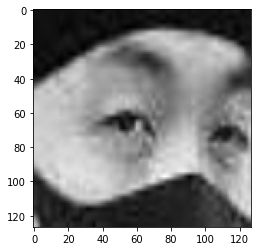

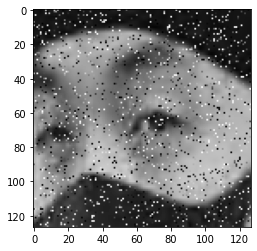

******
class: with_mask_faces


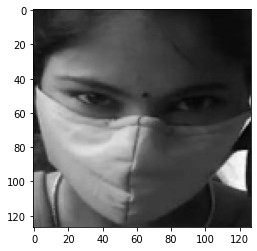

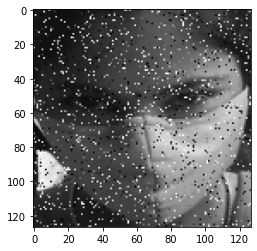

******
class: without_mask_faces


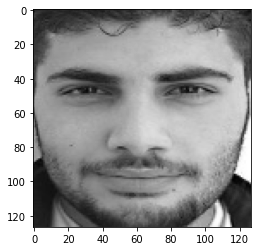

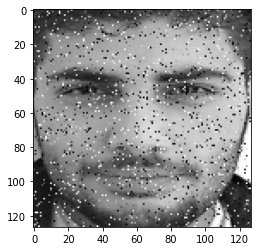

******


In [ ]:
# visualizing data with simple augmentation
# ------------------------------------------

# chekcing aug ops
# ----------------
randrange = random.sample(list(range(x_train.shape[0])), 3)
x_ran = copy.deepcopy(x_train[randrange])
y_ran = copy.deepcopy(y_train[randrange])
x_aug = imgaug_onthego_std(x_ran)

# for loop
# -------
for i in range(x_ran.shape[0]):

  ind_num = np.argwhere(y_ran[i]==1)[0,0]
  print('class: ' + class_labels[ind_num])
  plt.imshow(x_ran[i,:,:,0], cmap = 'gray')
  plt.show()
  plt.imshow(x_aug[i,:,:,0], cmap = 'gray')
  plt.show()
  print('******')

In [ ]:
# dataset tensors
# ---------------
x_trn = Variable(setup_image_tensor(x_train)).float()
y_trn = Variable(torch.from_numpy(y_train)).float()

x_tst = Variable(setup_image_tensor(x_test)).float()
y_tst = Variable(torch.from_numpy(y_test)).float()

print(x_trn.size())
print(y_trn.size())

print(x_tst.size())
print(y_tst.size())

torch.Size([1565, 1, 127, 127])
torch.Size([1565, 2])
torch.Size([392, 1, 127, 127])
torch.Size([392, 2])


In [ ]:
# end of data setup
#

**model setup & training**

In [ ]:
try:
  del model_cls
except:
  pass

# inits
# generator_1_127_one_hot_embedded 
# --------------------------------
model_cls = simple_classifier(y_trn.size()[1],x_trn.size()[1])
model_cls.apply(weights_init)
model_cls

simple_classifier(
  (image_encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Dropout2d(p=0.2, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Dropout2d(p=0.2, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Dropout2d(p=0.2, inplace=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.2, inplace=True)
    (15): Drop

In [118]:
# training loop
# model_train(xin,yin,load_mode,model,epochs,mbsize,save_state,base_name,path)
# ----------------------------------------------------------------------------

# model names
# ------------
# artivatic_2_face_image_classifier

# model save path set up
# ----------------------
cn_save_path = base_url + 'code/models/'

# declaring base name
# -------------------
base_name = 'eplane_mask_nomask_grayscale'

# trainng
# -------
no_epochs = -1
model_cls = model_train(x_trn,y_trn,'from saved',model_cls,no_epochs,64,True,base_name,cn_save_path)

Loading model from saved state...
Last saved recons loss - 0.007813301868736744
Last saved recons epoch - 2000
**********************
finished setting models up for GPU..


In [ ]:
# end of training
#

**inference - precision & recall**

In [119]:
# precision & recall on train data
# --------------------------------
randrange = random.sample(list(range(x_trn.size()[0])), 100)

# infeerence
# -----------
pred_out = model_cls.eval().cpu()(x_trn[randrange]/torch.max(x_trn[randrange]))


# getting scores
# --------------
_ = precision_recall_f1_accuracy(pred_out.cpu().data.numpy(),y_trn.cpu().data.numpy()[randrange],'sigmoid',class_labels)

Basic accuracy: 99.0%

Precision, recall and f1 scores: 
********************************

Label: without_mask_faces
------------
Precision: 1.0
Recall: 0.97
F1 Score: 0.99


Label: with_mask_faces
------------
Precision: 0.99
Recall: 1.0
F1 Score: 0.99




In [120]:
# precision & recall on test data
# --------------------------------
randrange = random.sample(list(range(x_tst.size()[0])), 100)

# infeerence
# -----------
pred_out_tst = model_cls.eval().cpu()(x_tst[randrange]/torch.max(x_tst[randrange]))


# getting scores
# --------------
_ = precision_recall_f1_accuracy(pred_out_tst.cpu().data.numpy(),y_tst.cpu().data.numpy()[randrange],'sigmoid',class_labels)

Basic accuracy: 90.0%

Precision, recall and f1 scores: 
********************************

Label: without_mask_faces
------------
Precision: 0.84
Recall: 0.95
F1 Score: 0.89


Label: with_mask_faces
------------
Precision: 0.96
Recall: 0.86
F1 Score: 0.91




**visualising the model**

class: without_mask_faces


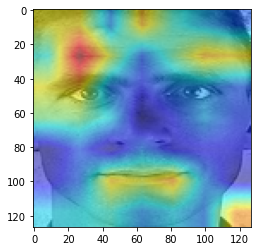

******


class: without_mask_faces


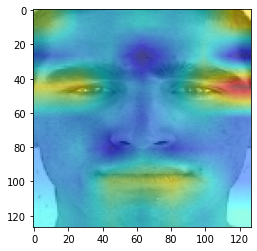

******


class: without_mask_faces


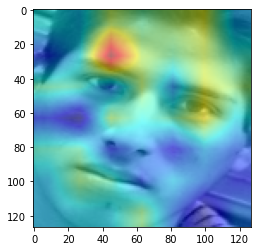

******


class: with_mask_faces


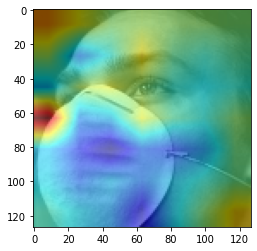

******


class: with_mask_faces


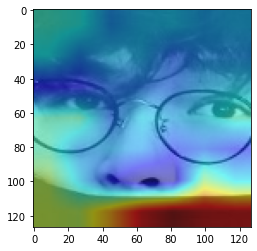

******




In [122]:
# visualising heatmaps
# --------------------
randrange = random.sample(list(range(x_tst.size()[0])), 5)

# running CAM
# -----------
d = CAM(x_tst[randrange], model_cls, layer=15)

# visualising d
# -------------
for i in range(len(d)):

  ind_num = np.argwhere(d[i]['pred']==1)[0,0]
  print('class: ' + class_labels[ind_num])
  plt.imshow(d[i]['heatmap'])
  plt.show()
  print('******\n\n')

In [3]:
# end of code
##
